In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import semua Library yang digunakan

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from shutil import copyfile
import matplotlib.pyplot as plt
import opendatasets as od
import shutil

In [ ]:
#Mendownload Datasheet
od.download("https://www.kaggle.com/datasets/fabinahian/plant-disease-45-classes")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: skyisnotyourlimit
Your Kaggle Key: ··········


100%|██████████| 3.00G/3.00G [00:36<00:00, 89.2MB/s]


<h1 align="center"><b>Berdasarkan Datasheet</h1> <br>
<h2 align="center">Yang Buah</h2>


1.   Apple
2.   Blueberry
3.   Cherry
4.   Corn
5.   Grape
6.  Orange
7. Peach
8. Pepper
9. Raspberry
10. Squash
11. StrawBerry
12. Tomato
13. Wheat

<h2 align="center">Yang Sayuran </h2>


1.   Rice
2.   Soybean
3. Pepper 





<h1 align="center"><b>Konfigurasi Directory Dataset</b></h1>


In [ ]:
#Alamat Sumber Dataset
alamat_sumber = "/content/plant-disease-45-classes/Plant World"
#Direktori Lama
directory_lama = alamat_sumber

#direktori baru yang akan menggabungkan seluruh gambar wheat
directory_baru = "/content/Wheat"

#Perintah untuk membuat direktori baru
os.mkdir(directory_baru)

file_list = os.listdir(directory_lama)

#Menggabungkan seluruh file dengan kata kunci wheat
for file_name in file_list:
  if "Wheat" in file_name:
    sumber = os.path.join(directory_lama, file_name)
    tujuan = os.path.join(directory_baru, file_name)
    shutil.copytree(sumber,tujuan)

In [ ]:
#Konfigurasi Data Foto
ukuran_gambar = 256 #Ukuran Gambar
batch_size = 32 #Mau 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_baru,
    seed=123,
    shuffle=True,
    image_size=(ukuran_gambar,ukuran_gambar),
    batch_size=batch_size)


Found 2942 files belonging to 3 classes.


<h1 align="center"><b> Training dan Split Data</h1><b>

In [ ]:
#Direktori pusat
pusat = "content/model"

#Buat direktori train dan test

def direktori(alamat):
  os.makedirs(os.path.join(alamat,'training','Wheat__Brown_Rust'))
  os.makedirs(os.path.join(alamat,'training','Wheat__Healthy'))
  os.makedirs(os.path.join(alamat,'training','Wheat__Yellow_Rust'))
  os.makedirs(os.path.join(alamat,'validation','Wheat__Brown_Rust'))
  os.makedirs(os.path.join(alamat,'validation','Wheat__Healthy'))
  os.makedirs(os.path.join(alamat,'validation','Wheat__Yellow_Rust'))
  os.makedirs(os.path.join(alamat,'test','Wheat__Brown_Rust'))
  os.makedirs(os.path.join(alamat,'test','Wheat__Healthy'))
  os.makedirs(os.path.join(alamat,'test','Wheat__Yellow_Rust'))
  
direktori(pusat)

In [ ]:
for rootdir, dirs, files in os.walk(pusat):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

content/model/validation
content/model/training
content/model/test
content/model/validation/Wheat__Healthy
content/model/validation/Wheat__Yellow_Rust
content/model/validation/Wheat__Brown_Rust
content/model/training/Wheat__Healthy
content/model/training/Wheat__Yellow_Rust
content/model/training/Wheat__Brown_Rust
content/model/test/Wheat__Healthy
content/model/test/Wheat__Yellow_Rust
content/model/test/Wheat__Brown_Rust


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, SPLIT_SIZE):
    """
    Parameter yang digunakan
    1) Source_DIR = Lokasi Awal
    2) Training_Dir = Lokasi data training
    3) Validation_Dir = Lokasi data validation
    4) Test_Dir = Lokasi data test
    5) Split_size = mau dipecah rasio berapa
    """
    file_names = os.listdir(SOURCE_DIR)
    random.shuffle(file_names)
    split_index = int(SPLIT_SIZE * len(file_names))
    validation_split_index = int((len(file_names) - split_index) / 2) + split_index

    training_files = file_names[:split_index]
    validation_files = file_names[split_index:validation_split_index]
    test_files = file_names[validation_split_index:]

    for file_name in training_files:
        source_path = os.path.join(SOURCE_DIR, file_name)
        dest_path = os.path.join(TRAINING_DIR, file_name)
        if os.path.getsize(source_path) > 0:
            copyfile(source_path, dest_path)
        else:
            print(f"{file_name} is zero length, so ignoring.")

    for file_name in validation_files:
        source_path = os.path.join(SOURCE_DIR, file_name)
        dest_path = os.path.join(VALIDATION_DIR, file_name)
        if os.path.getsize(source_path) > 0:
            copyfile(source_path, dest_path)
        else:
            print(f"{file_name} is zero length, so ignoring.")

    for file_name in test_files:
        source_path = os.path.join(SOURCE_DIR, file_name)
        dest_path = os.path.join(TEST_DIR, file_name)
        if os.path.getsize(source_path) > 0:
            copyfile(source_path, dest_path)
        else:
            print(f"{file_name} is zero length, so ignoring.")


In [ ]:
#Konfigurasi untuk menggunakan fungsi split_data
#Data Penyakit Tanaman
brown = "/content/Wheat/Wheat___Brown_Rust"
healthy = "/content/Wheat/Wheat___Healthy"
yellow = "/content/Wheat/Wheat___Yellow_Rust"

#Direktori train, validation, test
train = "/content/content/model/training"
validation = "/content/content/model/validation"
test = "/content/content/model/test"

#Direktori Semuanya
train_brown="/content/content/model/training/Wheat__Brown_Rust"
train_healthy="/content/content/model/training/Wheat__Healthy"
train_yellow="/content/content/model/training/Wheat__Yellow_Rust"

validation_brown ="/content/content/model/validation/Wheat__Brown_Rust"
validation_healthy="/content/content/model/validation/Wheat__Healthy"
validation_yellow="/content/content/model/validation/Wheat__Yellow_Rust"

test_brown="/content/content/model/test/Wheat__Brown_Rust"
test_healthy ="/content/content/model/test/Wheat__Healthy"
test_yellow="/content/content/model/test/Wheat__Yellow_Rust"

#Rasio = 0.8
rasio=0.8

#Menggunakan Fungsi Split Data
split_data(brown,train_brown,validation_brown,test_brown,0.8)
split_data(healthy,train_healthy,validation_healthy,test_healthy,0.8)
split_data(yellow,train_yellow,validation_yellow,test_yellow,0.8)

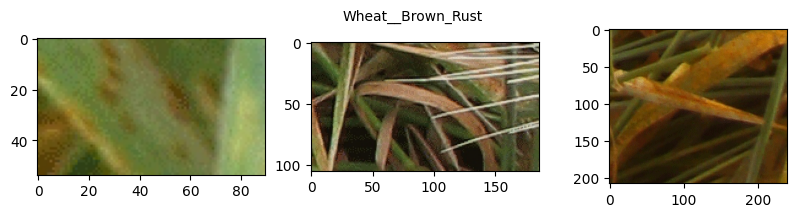

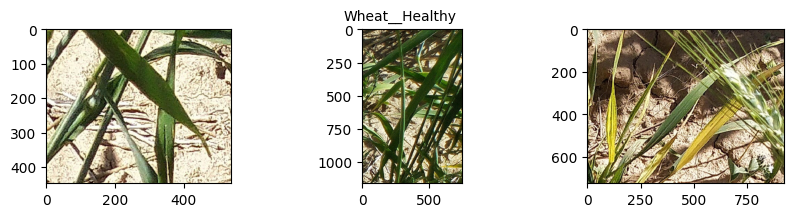

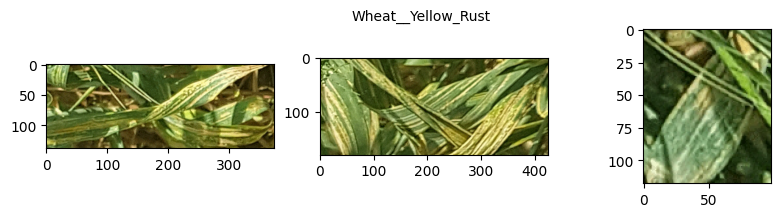

In [ ]:
nama = ["Wheat__Brown_Rust", "Wheat__Healthy", "Wheat__Yellow_Rust"]
alamat = ["/content/content/model/training/Wheat__Brown_Rust", "/content/content/model/training/Wheat__Healthy", "/content/content/model/training/Wheat__Yellow_Rust"]

def tampil_gambar(directory, label):
    plt.figure(figsize=(10, 2))
    plt.suptitle(label, fontsize=10)
    for i in range(3):
        alamat_gambar = os.path.join(directory, random.choice(os.listdir(directory)))
        gambar = plt.imread(alamat_gambar)
        plt.subplot(1, 3, i + 1)
        plt.imshow(gambar)
    plt.show()

for i, directory in enumerate(alamat):
    tampil_gambar(directory, nama[i])


<h1 align="center"><b> DATA AUGMENTASI</b></h1>


In [ ]:
def train_val_test_generators(training_dir, validation_dir,test_dir):

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  test_gen = ImageDataGenerator(rescale=1.0/255)

  test_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator,test_generator

In [ ]:
train_generator,validation_generator,test_generator = train_val_test_generators(train,validation,test)

Found 2352 images belonging to 3 classes.
Found 294 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


<h1 align="center"><b> Model</h1><b>

In [ ]:
def model():
  model_ = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="categorical_crossentropy",metrics="accuracy")
  return model_

In [ ]:
models=model()

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',save_weights_only=True,
                             verbose=1, save_best_only=True, mode='auto')

In [ ]:
history = models.fit(train_generator, epochs=30, verbose=1, validation_data=validation_generator,callbacks=[checkpoint])

Epoch 1/30
74/74 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.6620
Epoch 1: val_loss improved from inf to 0.44157, saving model to model.h5
74/74 [==============================] - 59s 614ms/step - loss: 0.7432 - accuracy: 0.6620 - val_loss: 0.4416 - val_accuracy: 0.8810
Epoch 2/30
74/74 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8622
Epoch 2: val_loss improved from 0.44157 to 0.34024, saving model to model.h5
74/74 [==============================] - 45s 608ms/step - loss: 0.3793 - accuracy: 0.8622 - val_loss: 0.3402 - val_accuracy: 0.8435
Epoch 3/30
74/74 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.8895
Epoch 3: val_loss improved from 0.34024 to 0.21700, saving model to model.h5
74/74 [==============================] - 46s 617ms/step - loss: 0.2789 - accuracy: 0.8895 - val_loss: 0.2170 - val_accuracy: 0.9252
Epoch 4/30
74/74 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9230
E

In [ ]:
test_loss, test_accuracy = model().evaluate(test_generator, verbose=1)

10/10 [==============================] - 3s 276ms/step - loss: 1.0849 - accuracy: 0.3784


In [ ]:
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 1.0849089622497559
Test Accuracy: 0.37837839126586914


<h1 align="center"><b>Grafik Plot</h1><b>

10/10 [==============================] - 2s 207ms/step - loss: 1.0927 - accuracy: 0.3378


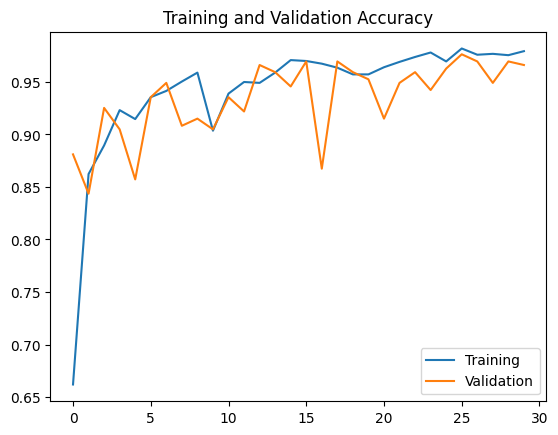

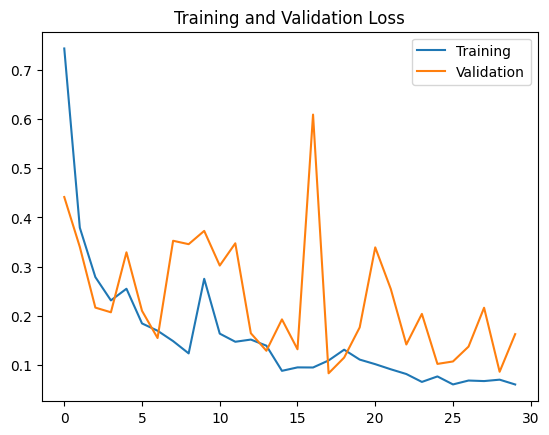

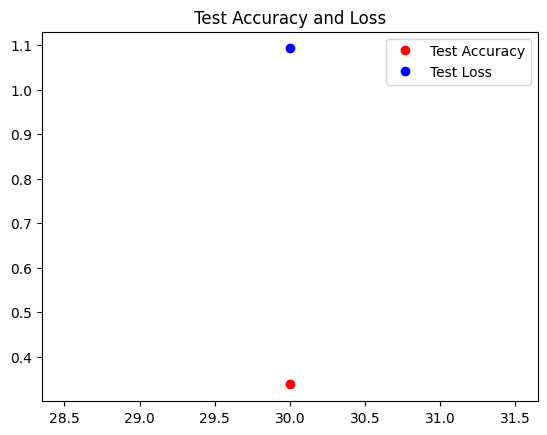

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

# Add test loss and test accuracy
test_loss, test_accuracy = model().evaluate(test_generator, verbose=1)
plt.plot(len(epochs), test_accuracy, 'ro', label='Test Accuracy')
plt.plot(len(epochs), test_loss, 'bo', label='Test Loss')
plt.title('Test Accuracy and Loss')
plt.legend()

plt.show()


<h1 align="center"><b> Hasil Akhir </b></h1>


1.   Akurasi Mencapai 96.60%
2.   Terdapat tanda tanda overfitting
3.   Tes Akurasi Masih Rendah (Antara saya salah atau bagaimana, saya tidak tau)

